# CNN ENC-DEC

In [18]:
# mount google drive & set working directory
# requires auth (click on url & copy token into text box when prompted)
from google.colab import drive
drive.mount("/content/gdrive")

import os
print(os.getcwd())

os.chdir('/content/gdrive/My Drive/Colab Notebooks/MidcurveNN')
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/MidcurveNN
/content/gdrive/My Drive/Colab Notebooks/MidcurveNN


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, optimizers
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from random import shuffle
import PIL
import json
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

In [20]:
# working directory
wdir = os.getcwd()
wdir

'/content/gdrive/My Drive/Colab Notebooks/MidcurveNN'

In [21]:
# _URL = 'https://drive.google.com/uc?export=download&id=16rqDFLO__WySSQGlAht0FEj2uJZg4M9M'

# path_to_zip = tf.keras.utils.get_file('input.zip',
#                                       origin=_URL,
#                                       extract=True)

# input_data_folder = os.path.join(os.path.dirname(path_to_zip), 'input')
input_data_folder = wdir + "/data/input"
print("input data dir: ", input_data_folder)

input data dir:  /content/gdrive/My Drive/Colab Notebooks/MidcurveNN/data/input


In [0]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [0]:
def get_training_data(datafolder = input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in midcurve_pngs]

#     profile_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in profile_pngs_objs])
#     midcurve_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in midcurve_pngs_objs])

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
#     profile_pngs_gray_objs = [np.where(x>128, 0, 1) for x in profile_pngs_gray_objs]
#     midcurve_pngs_gray_objs =[np.where(x>128, 0, 1) for x in midcurve_pngs_gray_objs]
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs

In [0]:
profile_pngs_objs, midcurve_pngs_objs = get_training_data()

In [0]:
def plot_results(original_imgs,computed_imgs,n=10):
    # n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

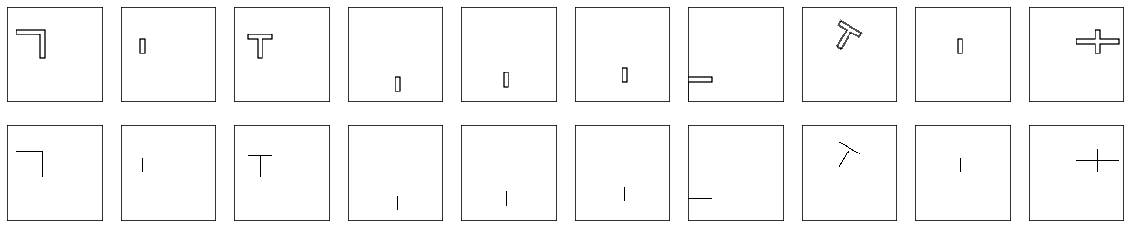

In [26]:
plot_results(profile_pngs_objs,midcurve_pngs_objs)

In [0]:
def get_train_test_split(profile_pngs_gray_objs, midcurve_pngs_gray_objs, encoding_dim=100, input_dim=100):

    # Training
    profile_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in profile_pngs_gray_objs]
    midcurve_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in midcurve_pngs_gray_objs]
    
    profile_pngs_objs = np.array(profile_pngs_flat_objs)
    midcurve_pngs_objs= np.array(midcurve_pngs_flat_objs)
    
    '''
    train_size = int(len(profile_pngs_objs)*0.7)
    x_train = profile_pngs_objs[:train_size]
    y_train = midcurve_pngs_objs[:train_size]
    x_test = profile_pngs_objs[train_size:]
    y_test = midcurve_pngs_objs[train_size:]
    '''
    x_train, x_test, y_train, y_test = train_test_split(profile_pngs_objs, midcurve_pngs_objs, 
                                                        test_size=0.3, random_state=42)
    return x_train, x_test, y_train, y_test

In [61]:
x_train, x_test, y_train, y_test = get_train_test_split(profile_pngs_objs, midcurve_pngs_objs)

print((len(x_train), len(y_train)), (len(x_test), len(y_test)))

(313, 313) (135, 135)


### Auto-encoder

In [0]:
def get_model_autoencoder():
    
    input_img = Input(shape=(100, 100, 1), name="input_img")  # adapt this if using `channels_first` image data format
    
    bn_model = 0
    p_activation = "elu"
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    #decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='valid')(x)
    
    '''
    bn_model = 0
    p_activation = "elu"
    x = Conv2D(16, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')((BatchNormalization(momentum=bn_model))(input_img))
    x = Conv2D(16, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer='random_uniform')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer='random_uniform')(x)

    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)

    x = Conv2D(128, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(encoded)
    x = Dropout(0.3)(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(x)
    x = Dropout(0.3)(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(x)
    x = Dropout(0.3)(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='elu', padding='same',kernel_initializer='random_uniform')(x)
    x = Conv2D(16, (3, 3), activation='elu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (2, 2), activation='sigmoid', padding='valid',name="decoded")(x)
    '''
    
    autoencoder = Model(input_img, decoded)
    optimizer = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy',)
    return autoencoder

In [68]:
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,AveragePooling2D,UpSampling2D

autoencoder = get_model_autoencoder()
autoencoder

In [0]:
# Compilation of Autoencoder (only)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
   

In [0]:
def fit_autoencoder(autoencoder, x_train, x_test, y_train, y_test):
    autoencoder.fit(x_train, y_train,
                epochs=200,
                batch_size=5,
                shuffle=True,
                validation_data=(x_test, y_test))
        
    encoded_imgs = autoencoder.predict(x_test)
    decoded_imgs = autoencoder.predict(encoded_imgs)    
        
    return x_test,decoded_imgs

In [71]:
original_test_imgs, decoded_imgs = fit_autoencoder(autoencoder, x_train, x_test, y_train, y_test)

Train on 313 samples, validate on 135 samples
Epoch 1/200
313/313 [==============================] - 2s 5ms/step - loss: -15.8929 - val_loss: -16.7512
Epoch 2/200
313/313 [==============================] - 0s 1ms/step - loss: -17.6441 - val_loss: -17.5076
Epoch 3/200
313/313 [==============================] - 0s 1ms/step - loss: -17.7530 - val_loss: -17.6072
Epoch 4/200
313/313 [==============================] - 0s 2ms/step - loss: -17.8378 - val_loss: -17.6708
Epoch 5/200
313/313 [==============================] - 0s 2ms/step - loss: -17.8700 - val_loss: -17.6653
Epoch 6/200
313/313 [==============================] - 0s 2ms/step - loss: -17.9027 - val_loss: -17.7295
Epoch 7/200
313/313 [==============================] - 1s 2ms/step - loss: -17.9071 - val_loss: -17.7072
Epoch 8/200
313/313 [==============================] - 0s 1ms/step - loss: -17.9235 - val_loss: -17.6861
Epoch 9/200
313/313 [==============================] - 0s 2ms/step - loss: -17.9458 - val_loss: -17.7704
Epoch 10/

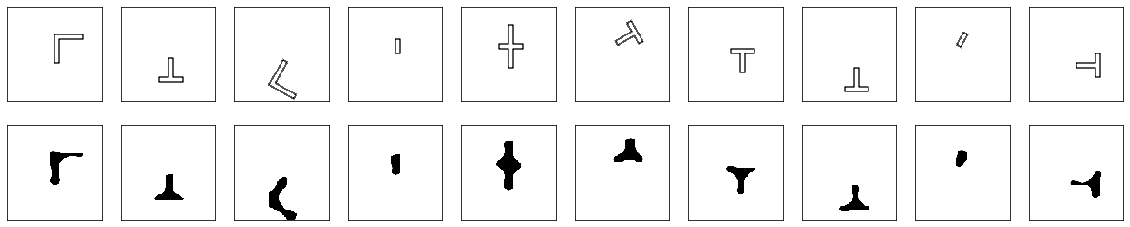

In [72]:
plot_results(original_test_imgs, decoded_imgs)